In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.ticker as mticker

from glob import glob
import cartopy.crs as ccrs
from matplotlib_scalebar.scalebar import ScaleBar
from ast import literal_eval
import contextily as cx
from matplotlib.colors import ListedColormap
import geopandas as gpd
from shapely.geometry.point import Point
from pyproj.database import query_utm_crs_info
from pyproj.aoi import AreaOfInterest
from pyproj import CRS
import string

In [2]:
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

## Read files

In [3]:
ds_mf = xr.open_dataset(glob('../data/ch4_cases/Azerbaijan/OSM_mf/*L2*nc')[0])
ds_lmf = xr.open_dataset(glob('../data/ch4_cases/Azerbaijan/OSM_lmf/*L2*nc')[0])

In [4]:
def add_scalebar(ax, lon, lat):
    # add scalebar
    # Geographic WGS 84 - degrees
    scale_points = gpd.GeoSeries([Point(lon-1, lat),
                                  Point(lon, lat)],
                                 crs=4326)

    # UTM projection
    utm_crs_list = query_utm_crs_info(
        datum_name='WGS 84',
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon,
            south_lat_degree=lat,
            east_lon_degree=lon,
            north_lat_degree=lat,
        ),
    )
    utm_epsg = CRS.from_epsg(utm_crs_list[0].code).to_epsg()

    # Projected WGS 84 - meters
    scale_points = scale_points.to_crs(utm_epsg)

    distance_meters = scale_points[0].distance(scale_points[1])
    scale_bar_location = 'lower right'
    
    scalebar = ScaleBar(distance_meters,
                        location=scale_bar_location,
                        color='w',
                        box_alpha=0,
                        font_properties={'size': 10},
                        )
    
    ax.add_artist(scalebar)

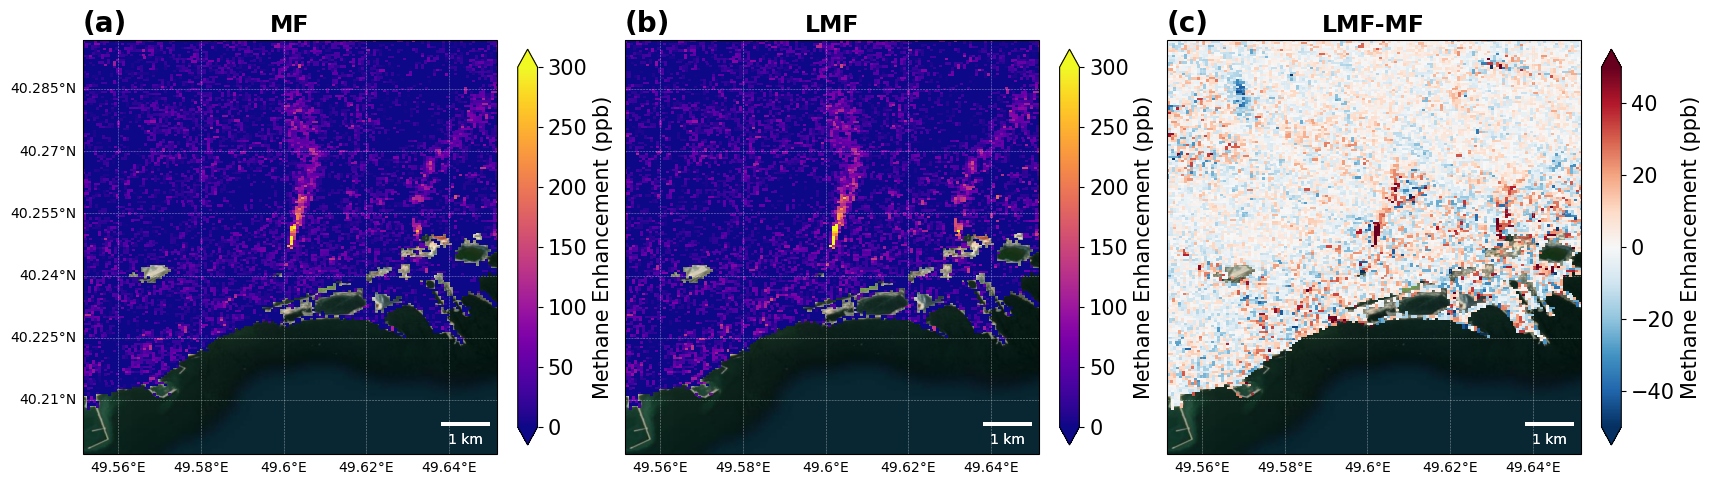

In [11]:
proj = ccrs.PlateCarree()

fig, axs = plt.subplots(nrows=1, ncols=3,
                        subplot_kw={'projection': proj},
                        figsize=(17, 8),
                        constrained_layout=True
                        )

# set extent
plume_longitude = 49.601544
plume_latitude = 40.246876
pad = 0.05
vmax = 300

lon_min = plume_longitude - pad
lon_max = plume_longitude + pad
lat_min = plume_latitude - pad
lat_max = plume_latitude + pad

for ax in axs:
    ax.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)
    cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
    # remove attributions
    ax.texts[-1].remove()

    # add scalebar
    add_scalebar(ax, lon_min, lat_min)
    
ax = axs[0]
m = ds_mf['ch4'].where(ds_mf['segmentation']==1).plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap='plasma',
                      add_colorbar=True, rasterized=True,
                      cbar_kwargs={'shrink': 0.5,
                                   'label': 'Methane Enhancement (ppb)'},
                     )
ax.set_title('MF')

ax = axs[1]
m = ds_lmf['ch4'].where(ds_mf['segmentation']==1).plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap='plasma',
                       add_colorbar=True, rasterized=True,
                      cbar_kwargs={'shrink': 0.5,
                          'label': 'Methane Enhancement (ppb)'},
                      )
ax.set_title('LMF')

ax = axs[2]
m = ((ds_lmf['ch4']-ds_mf['ch4']).where(ds_mf['segmentation']==1)).plot(ax=ax, x='longitude', y='latitude', vmin=-50, vmax=50, cmap='RdBu_r',
                                                         add_colorbar=True, rasterized=True,
                                                         cbar_kwargs={'shrink': 0.5,
                                                                      'label': 'Methane Enhancement (ppb)'},
                                                        )

ax.set_title('LMF-MF')

for n, ax in enumerate(axs.flatten()):
    add_scalebar(ax, ds_mf['longitude'].mean(), ds_mf['latitude'].mean())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='w', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = mticker.MaxNLocator(5)
    if n > 0:
        gl.left_labels = False
    
    ax.text(0, 1.02, '({})'.format(string.ascii_lowercase[n]),
            transform=ax.transAxes,
            size=20, weight='bold')

fig.savefig('../figures/ch4_mf_lmf.pdf', bbox_inches='tight')

In [6]:
# proj = ccrs.PlateCarree()

# fig, axs = plt.subplots(nrows=1, ncols=3,
#                         subplot_kw={'projection': proj},
#                         figsize=(15, 6),
#                         constrained_layout=True
#                         )

# # set extent
# lon_min = 49.4
# lon_max = 49.8
# lat_min = 40.2
# lat_max = 40.6

# for ax in axs:
#     ax.set_extent((lon_min, lon_max, lat_min, lat_max), crs=proj)
#     cx.add_basemap(ax, crs=proj, source=cx.providers.Esri.WorldImagery)
#     # remove attributions
#     ax.texts[-1].remove()

#     # add scalebar
#     add_scalebar(ax, lon_min, lat_min)
    
# ax = axs[0]
# m = ds_mf['ch4'].where(ds_mf['segmentation']==1).plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap='plasma',
#                       add_colorbar=True, rasterized=True,
#                       cbar_kwargs={'shrink': 0.65,
#                                    'label': 'Methane Enhancement (ppb)'},
#                      )
# ax.set_title('MF')

# ax = axs[1]
# m = ds_lmf['ch4'].where(ds_mf['segmentation']==1).plot(ax=ax, x='longitude', y='latitude', vmin=0, vmax=vmax, cmap='plasma',
#                        add_colorbar=True, rasterized=True,
#                       cbar_kwargs={'shrink': 0.65,
#                           'label': 'Methane Enhancement (ppb)'},
#                       )
# ax.set_title('LMF')

# ax = axs[2]
# m = ((ds_lmf['ch4']-ds_mf['ch4']).where(ds_mf['segmentation']==1)).plot(ax=ax, x='longitude', y='latitude', vmin=-50, vmax=50, cmap='RdBu_r',
#                                                          add_colorbar=True, rasterized=True,
#                                                          cbar_kwargs={'shrink': 0.65,
#                                                                       'label': 'Methane Enhancement (ppb)'},
#                                                         )

# ax.set_title('LMF-MF')

# for ax in axs:
#     add_scalebar(ax, ds_mf['longitude'].mean(), ds_mf['latitude'].mean())
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=0.4, color='w', alpha=0.5, linestyle='--')
#     gl.top_labels = False
#     gl.right_labels = False
#     gl.xlocator = mticker.MaxNLocator(5)

# for n, ax in enumerate(axs.flatten()):
#     ax.text(0, 1.02, '({})'.format(string.ascii_lowercase[n]),
#             transform=ax.transAxes,
#             size=20, weight='bold')

# # fig.savefig('../figures/ch4_mf_lmf.pdf', bbox_inches='tight')